In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
from fluidvec import *

In [4]:
import torch
import pickle
from torch.optim import AdamW
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
from fluidvec.dataset import TrainDataset, get_dataloader
# torch.autograd.set_detect_anomaly(True)

In [5]:
with open("../data/train_items/train_items_001.pkl", "rb") as fin:
    items = pickle.load(fin)

In [6]:
items[100]

({'compos': [67, 68, 69, 70, 48, 49], 'chars': [47, 125, 31], 'word': 77},
 [{'compos': [8], 'chars': [97], 'word': 60},
  {'compos': [119, 157, 107, 131, 8], 'chars': [122, 123, 124], 'word': 76},
  {'compos': [67, 68, 69, 70, 158, 159], 'chars': [47, 125, 126], 'word': 78},
  {'compos': [78, 160, 50, 52, 8], 'chars': [127, 35, 128], 'word': 79}])

In [8]:
vs = VocabSet.load()
word_weights = [vs.word_vocab.freq[idx]**0.75 for idx in range(len(vs.word_vocab))]

use_cuda = True and torch.cuda.is_available()
model = FluidVecSG(len(vs.word_vocab), len(vs.char_vocab), len(vs.compo_vocab), 
                   dim=50, n_neg_sample=3, weights=word_weights, use_cuda=use_cuda)
optim = AdamW(model.parameters(), lr=1e-3)
if use_cuda:
    model.to(torch.device("cuda"))

device:  cuda
n_neg_sample:  3


In [8]:
train_dir = Path("../data/train_items")
train_files = list(train_dir.iterdir())

In [9]:
model = FluidVecSG(len(vs.word_vocab), len(vs.char_vocab), 0, 
                   dim=50, n_neg_sample=3, weights=word_weights, use_cuda=use_cuda)


device:  cuda
n_neg_sample:  3


In [10]:
model(items[:4])

RuntimeError: Input, output and indices must be on the current device

In [11]:
pool_vec = []
loss_veclist = []
for data_path in train_files[:5]:
    loss_vec = []
    loader = get_dataloader(str(data_path))
    for batch in tqdm(loader, desc=data_path.name):
        optim.zero_grad()
        loss = model(batch)
        loss.backward()
        optim.step()            
        loss_vec.append(loss.cpu().item())        
        break
    avg_loss = sum(loss_vec) / len(loss_vec)
    loss_veclist.append(loss_vec)
    pool_vec.append(avg_loss)

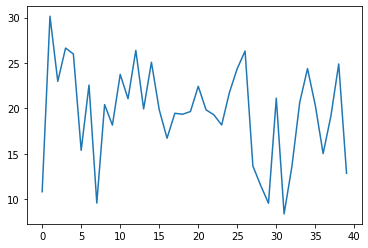

In [15]:
plt.plot(pool_vec)

In [16]:
loss_vec = loss_veclist[-1]
coeff = .99
for x in loss_vec:
    if loss_sm:        
        loss_sm.append(x*(1-coeff)+loss_sm[-1]*coeff)
    else:
        loss_sm.append(x)
plt.plot(loss_sm)

NameError: name 'loss_sm' is not defined

In [17]:
model.word_emb.num_embeddings

217350

In [15]:
from pathlib import Path
import pickle
model_dir = Path("../data/model/fluidvec-compo.1")
model_dir.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_dir/"model.pt")
torch.save(model.hyperparameters(), model_dir/"hypers.pt")
vocab_path = model_dir/"vocab.pkl"
vs.save(model_dir)

In [16]:
new_vs = VocabSet.load(model_dir)
hypers = torch.load(model_dir/"hypers.pt")
new_model = FluidVecSG(len(new_vs.word_vocab), len(new_vs.char_vocab), len(new_vs.compo_vocab), **hypers)
new_model.load_state_dict(torch.load(model_dir/"model.pt"))

device:  cpu
n_neg_sample:  3


<All keys matched successfully>